### Libraries

In [1]:
import sys
sys.path.insert(0,'/Users/jarad/Fake Folder/Python Libraries/')

from jb_libraries import *
from part_categories_data import *
from part_cost_data import *

%matplotlib inline

import xlwings as xw


== part_categories start ==


your df is called "all_cats_df"


== part_categories end ==


== part_cost_data start ==

0 nulls
the mean_stripe_margin is 77.44%

the part types with no MSRP are/is: ['sku']

avg gross profit for:
parts, combos, and stripes
which have been purchased within the last year
whose sku_status equals "working"
whose msrp is greater than zero
which were bought by non resellers
is 56.04%

the parts with negative gross profit are: [2885, 3400]

your dfs are: all_cost (cost on the sku level) and all_cost_by_part (cost on the part level)

== part_cost_data end ==



### Script settings

In [78]:
report_type = 'year and month'
date_end = '2019-01-31'

close_workbook = 'no'
write_pdf = 'yes'

In [3]:
report_dict = {}
now_pretty = str(dt.datetime.now().date())

particle_parts = [3450,3451,3452,3453,3455,3454,3234,3233,2798,2725,2721,2723,2724,3051,3457,2799,3233,3234,2722]
particle_date = '2018-08-01'

In [4]:
if report_type == 'year and month':
    date_start = str((pd.to_datetime(date_end) - pd.DateOffset(years = 1)).date())[:7] + '-01'
    period = 12
    workbook_title = date_end[:4] + ' - ' + date_end[5:7] + ' - ' + calendar.month_abbr[int(date_end[5:7])] + ' - Monthly Products Report'
    report_title = workbook_title
    report_date_start = date_end[:7] + '-01'
    report_type_pretty = jb_dates(pd.Series(pd.to_datetime(date_end)), report_type + ' pretty')[0]
    p2p = 'M2M '
    
elif report_type == 'year and quarter':
    date_start = str((pd.to_datetime(date_end) - pd.DateOffset(years = 2, months = 2)).date())[:7] + '-01'
    period = 4
    workbook_title = date_end[:4] + ' - Q' + str(pd.to_datetime(date_end).quarter) + ' - Quarterly Products Report'
    report_title = workbook_title
    report_date_start = str((pd.to_datetime(date_end) - pd.DateOffset(months = 2)).date())[:7] + '-01'
    report_type_pretty = jb_dates(pd.Series(pd.to_datetime(date_end)), report_type + ' pretty')[0]
    p2p = 'Q2Q '
    
elif report_type == 'year':
    date_start = str((pd.to_datetime(date_end) - pd.DateOffset(years = 4, months = 11)).date())[:7] + '-01'
    period = 1
    workbook_title = date_end[:4] + ' - Annual Products Report'
    report_title = workbook_title
    report_date_start = str((pd.to_datetime(date_end) - pd.DateOffset(months = 11)).date())[:7] + '-01'
    report_type_pretty = date_end[:4]
    p2p = ''

### Paths

In [5]:
csv_path = '/Users/jarad/Fake Folder/InterDept/Recurring/Products Report/CSVs/'

html_path = '/Users/jarad/Fake Folder/InterDept/Recurring/Products Report/HTML/'
html_title = 'Products Report.html'

style_sheet_path = '/Users/jarad/Fake Folder/CSS Stylesheets/Recurring Reports Stylesheet.css'

pdf_path = '/Users/jarad/Fake Folder/InterDept/Recurring/Products Report/Docs/' + report_type.split(' ')[-1].title() + 'ly' + ' Reports/'

image_path = '/Users/jarad/Fake Folder/InterDept/Recurring/Products Report/Images/'

### Get sales data

In [6]:
time_start = dt.datetime.now()

In [7]:
op_super_main = pd.read_sql(
'''
SELECT
DATE(date_purchased) AS date_purchased,
op.orders_id,
part_id,
products_quantity AS qty_total,
products_quantity_free AS qty_free,
products_quantity - products_quantity_free AS qty_bought,
products_price,

CASE 
WHEN orders_reseller = 0 AND orders_super_reseller = 0 THEN 'non reseller'
WHEN orders_reseller = 1 AND orders_super_reseller = 0 THEN 'reseller'
WHEN orders_super_reseller = 1 THEN 'super reseller'
ELSE 'you missed one'
END AS 'customer'

FROM orders_products op
JOIN orders o ON op.orders_id = o.orders_id
WHERE DATE(o.date_purchased) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
AND o.orders_status NOT IN (8,9,10,11,12,14,15)
AND o.payment_method != 'Replacement Order'
''', db)

col_fix(op_super_main)

op_super_main['date purchased'] = pd.to_datetime(op_super_main['date purchased'])
for col in ['year and month','year and quarter']:
    op_super_main[col] = jb_dates(op_super_main['date purchased'], col)
    
op_super_main['year'] = op_super_main['date purchased'].dt.year    
op_super_main['year'] = op_super_main['year'].map(str)

In [8]:
time_end = dt.datetime.now()
m = (time_end - time_start).seconds/60
print('{:,.0f} minutes'.format(m))

1 minutes


### Make a copy

In [9]:
op_main = op_super_main.copy()

### Get cost data

In [10]:
cols = all_cost_by_part.columns.tolist()
cols.remove('part id')
for c in cols:
    op_main[c] = op_main['part id'].map(dict(zip(all_cost_by_part['part id'], all_cost_by_part[c])))
op_main.rename(columns = {'latest cost':'cost per unit'}, inplace = True)

### Fix stripe cost prior to when we started pricing as we do currently

In [11]:
d = '2018-05-01'
stripe_ls = op_main[op_main['type'] == 'stripe']['part id'].tolist()
op_main['cost per unit'] = np.where((op_main['part id'].isin(stripe_ls)) & (op_main['date purchased'] <= d), 
                                        (1 - mean_stripe_margin) * op_main['products price'],
                                        op_main['cost per unit'])

### Fix particle cost

In [12]:
op_main['cost per unit'] = np.where((op_main['part id'].isin(particle_parts))
                                  & (op_main['date purchased'] < particle_date),
                                    0,
                                    op_main['cost per unit'])
op_main['total cost'] = op_main['cost per unit'] * op_main['qty total']    

### Fix partical revenue

In [13]:
op_main['revenue'] = op_main['qty bought'] * op_main['products price']
op_main['revenue'] = np.where((op_main['part id'].isin(particle_parts))
                              & (op_main['date purchased'] < particle_date),
                              1,
                              op_main['revenue'])

### Get gross profit

In [14]:
op_main['gross profit'] = op_main['revenue'] - op_main['total cost']
op_main['gross profit margin'] = op_main['gross profit']/op_main['revenue']    
op_main['gross profit margin'] = op_main['gross profit margin'].replace([np.inf,-np.inf], 0)

### Get sku data

In [15]:
skus_super_main = pd.read_sql(
'''
SELECT
sku_id,
part_id,
LOWER(bom_type) AS bom_type,
IF(sku_outsourced_assembly = 1, 'yes','no') AS consigned,
sku_date_modified,
sku_status
FROM skus
''', db)

col_fix(skus_super_main)
skus_main = skus_super_main.copy()

# put multiple BOM types per single PN on one line
a = skus_main.copy()
a.drop_duplicates(['part id','bom type'], inplace = True)
b = a.groupby('part id')['bom type'].apply(lambda x: ', '.join(x))
c = b.to_dict()

skus_main['bom type'] = skus_main['part id'].map(c)

ls = ['bom type','consigned']
for col in ls:
    op_main[col] = op_main['part id'].map(dict(zip(skus_main['part id'], skus_main[col])))
    
for x in ['type','bom type']:
    op_main[x].fillna('adabox subscription/partnership/other', inplace = True)    
    
op_main['consigned'].fillna('no', inplace = True)

### Alt BOM type
Some parts have multiple BOMs

This report is on the part level, so each part must have a single BOM

Do that here

In [16]:
alt_bom = skus_super_main.sort_values(['part id','sku date modified']).drop_duplicates('part id', keep = 'last')
alt_bom_d = dict(zip(alt_bom['part id'],alt_bom['bom type']))

op_main['alt bom type'] = op_main['part id'].map(alt_bom_d)
op_main['alt bom type'].fillna(op_main['type'], inplace = True)

### Get products name

In [17]:
pd_main = pd.read_sql(
'''
SELECT
part_id,
products_name
FROM products_description
''', db)

col_fix(pd_main)

op_main['products name'] = op_main['part id'].map(dict(zip(pd_main['part id'], pd_main['products name'])))

### Get categories

In [18]:
op_main['category'] = op_main['part id'].map(dict(zip(all_cats_df['part id'], all_cats_df['cat name'])))
op_main['category'].fillna('adabox/partnership/other', inplace = True)  

### Get new products

In [19]:
parts = pd.read_sql(
'''
SELECT
part_id,
DATE(products_date_added) AS date_added
FROM parts
''', db)

col_fix(parts)
parts['date added'] = pd.to_datetime(parts['date added'])

op_main['date added'] = op_main['part id'].map(dict(zip(parts['part id'], parts['date added'])))

d = str(pd.to_datetime(report_date_start[:7] + '-01').date())

op_main['new product'] = np.where((op_main['date purchased'].between(report_date_start, date_end)
                                & (op_main['date added'].between(report_date_start, date_end))), 'yes','no')

for col in ['year and month','year and quarter']:
    op_main[col + ' added'] = jb_dates(op_main['date added'], col)
    
op_main['year added'] = op_main['date added'].dt.year    
op_main['year added'] = op_main['year added'].map(str)
op_main['new product over time'] = np.where(op_main[report_type] == op_main[report_type + ' added'], 'yes','no')

new_p_check = op_main[(op_main['new product'] == 'yes') & (op_main['new product over time'] == 'no')]
if new_p_check.empty == False:
    raise ValueError('check your new products dates!')    

### Get partnerships

In [20]:
partner = pd.read_sql(
'''
SELECT
part_id
FROM products_description
WHERE products_name LIKE '%partner%'
''', db)

col_fix(partner)
p = partner['part id'].tolist()

op_main['customer'] = np.where(op_main['part id'].isin(p), 'partnership', op_main['customer'])

In [21]:
partner

,part id
0,3188
1,1245
2,1205


### Get adabox

In [22]:
adabox = pd.read_sql(
'''
SELECT
orders_id
FROM subscriptions_history
''', db)

col_fix(adabox)

op_main['adabox'] = np.where(op_main['orders id'].isin(adabox['orders id'].tolist()), 'yes','no')

### Compare with daily stats

In [23]:
ds = pd.read_sql(
'''
SELECT
DATE_FORMAT(timestamp, '%Y-%m') AS year_and_month,
SUM(d_value) AS PLM_revenue
FROM daily_stats
WHERE d_class = 'd_all'
AND DATE(timestamp) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
GROUP BY DATE_FORMAT(timestamp, '%Y-%m')
''', db)

col_fix(ds)
ds.set_index('year and month', inplace = True)

In [24]:
particle_check = pd.read_sql(
'''
SELECT
DATE_FORMAT(o.date_purchased, '%Y-%m') AS year_and_month,
SUM((op.products_quantity - op.products_quantity_free) * op.products_price) AS particle_revenue,
SUM(op.products_quantity - op.products_quantity_free) AS qty
FROM orders_products op
JOIN orders o ON op.orders_id = o.orders_id
AND DATE(o.date_purchased) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
AND o.orders_status NOT IN (8,9,10,11,12,14,15)
AND o.payment_method != 'Replacement Order'
WHERE op.part_id IN '''+ str(tuple(particle_parts)) +'''
GROUP BY DATE_FORMAT(o.date_purchased, '%Y-%m')
''', db)

col_fix(particle_check)

particle_check.set_index('year and month', inplace = True)

In [25]:
particle_fix_for_check = op_main[op_main['part id'].isin(particle_parts)].groupby('year and month')[['revenue']].sum().rename(columns = {'revenue':'prod report particle revenue'})

In [26]:
refunds01 = pd.read_sql(
'''
SELECT
DATE_FORMAT(o.date_purchased, '%Y-%m') AS year_and_month,
ot.orders_id,
ot.value AS ot_rev
FROM orders_total ot
JOIN orders o ON ot.orders_id = o.orders_id
AND DATE(o.date_purchased) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
AND o.orders_status NOT IN (8,9,10,11,12,14,15)
AND o.payment_method != 'Replacement Order'
WHERE ot.class = 'ot_subtotal'
''', db)

refunds02 = pd.read_sql(
'''
SELECT
o.orders_id AS orders_id,
SUM((op.products_quantity - op.products_quantity_free) * op.products_price) AS op_rev
FROM orders o
JOIN orders_products op ON o.orders_id = op.orders_id
WHERE DATE(o.date_purchased) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
AND o.orders_status NOT IN (8,9,10,11,12,14,15)
AND o.payment_method != 'Replacement Order'
GROUP BY op.orders_id
''', db)

for df in [refunds01,refunds02]:
    col_fix(df)

refunds_main = refunds01.merge(refunds02, on = 'orders id')
refunds_main['refunds'] = refunds_main['ot rev'] - refunds_main['op rev']
refunds = refunds_main.groupby('year and month')[['refunds']].sum()

In [27]:
check = op_main.groupby('year and month')[['revenue']].sum().rename(columns = {'revenue':'prod report revenue'}).join(ds).join(particle_check).join(particle_fix_for_check).join(refunds)
check['prod report particle revenue'] = check['prod report particle revenue'] * -1
check = check[['prod report revenue',
               'prod report particle revenue',
               'particle revenue',
               'refunds',
               'PLM revenue']]
check['difference'] = check['PLM revenue'] - (check.sum(1) - check['PLM revenue'])
check.reset_index(inplace = True)

def diff(x):
    if (x['difference'] > -1) and (x['difference'] < 1):
        return 0
    else:
        return x['difference']

check['difference'] = check.apply(diff, axis = 1)

check = check.iloc[-13:].copy()

In [28]:
fmt = [0] + ['m0'] * (len(check.columns) - 1)
check.format_(fmt).replace('$nan','')

,Year And Month,Prod Report Revenue,Prod Report Particle Revenue,Particle Revenue,Refunds,Plm Revenue,Difference
0,2018-01,"$3,526,516",$-137,"$12,440",$701,"$3,539,520",$0
1,2018-02,"$3,295,116",$-177,"$14,819","$2,781","$3,312,539",$0
2,2018-03,"$4,351,348",$-168,"$14,919","$3,347","$4,369,446",$0
3,2018-04,"$3,692,545",$-126,"$11,001","$1,855","$3,705,275",$0
4,2018-05,"$3,933,196",,,$761,"$3,933,958",$0
5,2018-06,"$3,272,137",,,$717,"$3,272,854",$0
6,2018-07,"$3,448,094",,,$646,"$3,448,739",$0
7,2018-08,"$3,141,404",$-674,$674,$418,"$3,141,821",$0
8,2018-09,"$3,079,352","$-7,364","$7,364","$2,068","$3,081,420",$0
9,2018-10,"$4,166,175","$-9,444","$9,444",$364,"$4,166,539",$0


### Profit losses

In [29]:
loss_main = op_main[op_main['gross profit'] < 0].copy()
g1 = loss_main.groupby(report_type)[['gross profit']].sum()
g1 = g1 * -1

fmt = ['m0']
print('avg loss per ' + report_type)
display(jb_conf(g1).loc[:'upper'].format_(fmt))

print('\ngross profit losses')
g1.format_(fmt)

avg loss per year and month


,Gross Profit
lower,"$14,413"
mean,"$16,606"
upper,"$18,800"



gross profit losses


,Gross Profit
year and month,
2018-01,"$23,124"
2018-02,"$18,130"
2018-03,"$18,940"
2018-04,"$14,556"
2018-05,"$15,382"
2018-06,"$8,724"
2018-07,"$10,088"
2018-08,"$13,685"
2018-09,"$14,138"


In [30]:
cur_loss = loss_main[loss_main['date purchased'].between(report_date_start, date_end)]

cur_loss_all = cur_loss.groupby(['part id','products name'])[['gross profit','qty bought','qty free','qty total']].sum()
cur_loss_all.sort_values('gross profit', inplace = True)
cur_loss_all.loc[('','column total'),:] = cur_loss_all.sum()

fmt = ['m0','n0','n0','n0']
print('with freebies')
display(cur_loss_all.format_(fmt))

print('without freebies')
cur_loss_no_freebies = cur_loss[cur_loss['qty free'] == 0].groupby(['part id','products name'])[['gross profit','qty bought','qty free','qty total']].sum()
cur_loss_no_freebies.sort_values('gross profit', inplace = True)
cur_loss_no_freebies.loc[('','column total'),:] = cur_loss_no_freebies.sum()

fmt = ['m0']
cur_loss_no_freebies[['gross profit']].format_(fmt)

with freebies


,,Gross Profit,Qty Bought,Qty Free,Qty Total
part id,products name,,,,
3333,Circuit Playground Express,"$-7,743",0,934,934
3400,Raspberry Pi Zero W,"$-3,888","1,944",0,"1,944"
1609,Adafruit Perma-Proto Half-sized Breadboard PCB - Single,"$-2,348",0,"4,792","4,792"
2885,Raspberry Pi Zero - Version 1.3,"$-2,166",619,0,619
3713,Adafruit PCB Coaster - Hans + Adabot,"$-1,029",0,405,405
3710,Adafruit PCB Coaster - Minerva + Adabot,$-960,0,378,378
3524,Make: Magazine - Vol 57,$-945,0,315,315
3711,Adafruit PCB Coaster - Cappy + Adabot,$-922,0,363,363
3712,Adafruit PCB Coaster - LEDs + Adabot,$-803,0,316,316


without freebies


,,Gross Profit
part id,products name,
3400,Raspberry Pi Zero W,"$-3,888"
2885,Raspberry Pi Zero - Version 1.3,"$-2,166"
3418,Digital Loggers PLDuino - ATmega2560 + ESP8266 Customizable PLC,$-240
3283,Red Bear IoT pHAT for Raspberry Pi - WiFi + BTLE,$-232
3329,Red Bear IoT pHAT for Raspberry Pi - WiFi + BTLE - unassembled,$-66
1484,32x32 RGB LED Matrix Panel - 6mm pitch,$-23
2472,Adafruit 9-DOF Absolute Orientation IMU Fusion Breakout - BNO055,$-10
4064,Adafruit Grand Central M4 Express featuring the SAMD51,$-10
3595,"Adafruit APDS9960 Proximity, Light, RGB, and Gesture Sensor",$-3


### Unspecified parts

In [31]:
op_main[op_main['alt bom type'] == 'unspecified'][['part id','products name']].drop_duplicates()

,part id,products name
49107,3256,Kano Screen Kit
625463,3784,4 x AA Battery Holder with 2.1mm Plug


# Explore for report

# Excel Start

### Set up workbook

In [44]:
workbook = xlsxwriter.Workbook(csv_path + workbook_title + '.xlsx',
                               {'nan_inf_to_errors': True,
                               'strings_to_numbers': True})

tabs = ['Overview',
        'All Customers',
        'Resellers',
        'Super Resellers',
        'Manufacturing',
        'New Products',
        'By Category',
        'By Bom',
        'Losses',
        'Notes on Revenue Totals']

#=========================
# Formats
#=========================

colors = ['#343635',
          '#2e4874',
          '#7eaba4',
          '#928c85',
          '#347c83',
          '#bfb9d6']
colors = colors * 2

title = workbook.add_format({'font_size':25,
                             'font_name':'Arial (Bold)'})

subtitle = workbook.add_format({'font_size':15,
                                 'font_name':'Arial (Bold)'})


col_names = workbook.add_format({'font_name':'Arial (Bold)',
                                 'font_color':'white',
                                 'valign':'vcenter',
                                 'align':'center',
                                 'bg_color':colors[2],
                                 'bottom':1,
                                 'top':1,
                                 'left':1,
                                 'right':1})

money = workbook.add_format({'num_format':'$#,##0'})
money2 = workbook.add_format({'num_format':'$#,##0.00'})
percent = workbook.add_format({'num_format':'0.0%'})
number = workbook.add_format({'num_format':'#,##0'})
dummy = workbook.add_format({'font_color':'black'})

for tab in tabs:
    workbook.add_worksheet(tab) # create each tab

my_worksheets = {}
for sht in workbook.worksheets():
    my_worksheets[sht.get_name()] = sht # create dict like tab_name:worksheet_instance

#=========================
# Apply same formatting to each worksheet
#=========================

for k, v in my_worksheets.items():
    sht = my_worksheets[k]
    sht.write(0, 0,
              k.title(),
              title)
    sht.write(1, 0,
              workbook_title,
              subtitle)

### Overview

In [45]:
#=========================
# Main df
#=========================

df = op_main.groupby([report_type,'customer']).agg({'revenue':'sum',
                                                    'gross profit':'sum',
                                                    'orders id':'nunique'}).rename(columns = {'orders id':'orders'})
#=========================
# Totals
#=========================

totals = df.groupby(level = 0).sum()
ls = totals.columns.tolist()
ls2 = ['total ' + x for x in ls]
totals.columns = ls2

overview_d = {}

#=========================
# Revenue, gross profit, orders
#=========================

col_order = ['non reseller', 'reseller', 'super reseller', 'partnership']
for col in df.columns:
    df2 = df[[col]].unstack()
    df2.columns = df2.columns.droplevel(0)
    df2 = df2[col_order]
    
    df3 = df2.join(totals[['total ' + col]])    
    overview_d[col] = df3
    
    mean = pd.DataFrame(df3.mean())
    mean.columns = [report_type.split(' ')[-1] + 'ly avg']
    mean.index.name = 'customer'
    
    overview_d[col + ' mean'] = mean
    
#=========================
# AOV
#=========================    
    
aov = df[['revenue']].div(df[['orders']].values)
aov.columns = ['aov']
aov2 = aov.unstack()
aov2.columns = aov2.columns.droplevel(0)
aov2 = aov2[col_order]
aov2['overall aov'] = totals[['total revenue']].div(totals[['total orders']].values)    
overview_d['aov'] = aov2

mean = pd.DataFrame(aov2.mean())
mean.columns = [report_type.split(' ')[-1] + 'ly avg']    
overview_d['aov mean'] = mean

#=========================
# Gross profit margin
#=========================

pm = df[['gross profit']].div(df[['revenue']].values)
pm.columns = ['gross profit margin']
pm2 = pm.unstack()
pm2.columns = pm2.columns.droplevel(0)
pm2 = pm2[col_order]
pm2['overall gross profit margin'] = totals[['total gross profit']].div(totals[['total revenue']].values)
overview_d['gross profit margin'] = pm2

mean = pd.DataFrame(pm2.mean())
mean.columns = [report_type.split(' ')[-1] + 'ly avg']    
overview_d['gross profit margin mean'] = mean

#=========================
# period to period (p2p) % changes
#=========================

ls = list(overview_d.keys())
for x in ls:
    if 'mean' in x:
        ls.remove(x)
        
for l in ls:
    y = overview_d[l]
    
    p2p_changes = y.pct_change()
    
    if report_type != 'year':
        yoy = y.pct_change(periods = period).iloc[[-1]]
        yoy.index.values[0] = 'YoY'

        y2 = pd.concat([p2p_changes, yoy], sort = False)
        overview_d[l + ' changes'] = y2        
    else:
        overview_d[l + ' changes'] = p2p_changes
    
#=========================
# Charts
#=========================    
    
ls1 = list(overview_d.keys())
ls2 = []
for x in ls1:
    if 'mean' in x or 'changes' in x:
        ls2.append(x)
ls3 = sorted(list(set(ls1) - set(ls2)))

markers = ['8','x','^','D','P']
formats = ['${:,.2f}','${:,.0f}','{:,.1f}%','{:,.0f}','${:,.0f}']
mult = [1,1,100,1,1]

d = {z[0]:list(z[1:]) for z in zip(ls3,markers,formats,mult,colors)}

for col in ls3:

    fig, ax = plt.subplots(figsize = (10,5))

    df = overview_d[col].iloc[:,-1]
    
    df.plot(ax = ax,
            lw = 5,
            marker = d[col][0],
            color = d[col][-1],
            mew = 8)
    
    avg_plot = ax.axhline(df.mean(), ls = '--', color = 'black', lw = 3, label = 'Average')
    
    ax.grid(color = 'black', alpha = 0.35)

    n = len(df3)
    ax.set_xticks(range(n))

    xticks = jb_dates(pd.Series(df3.index), report_type + ' xticks')
    ax.set_xticklabels(xticks, fontsize = 10)
    ax.set_xlabel('')
    
    ax.set_yticklabels([d[col][1].format(x * d[col][2]) for x in ax.get_yticks()],
                      fontsize = 10)
    
    ax.set_title(col.title(), fontsize = 15)
    ax.legend(handles = [avg_plot], fontsize = 10, loc = 'lower left', frameon = True, edgecolor = 'black')
    
    overview_d[col + ' chart'] = fig
    plt.close()
    
#=========================
# Write data
#=========================

#=========================
# First tables
#=========================

fmt = {'revenue':money,
       'gross profit':money,
       'gross profit margin':percent,
       'orders':number,
       'aov':money2}

ls = list(fmt)

start_row = 3
start_col = 0

sht = my_worksheets['Overview']

for k in ls:
    
    sht.write(start_row, start_col, k.title(), subtitle)

    df = overview_d[k].reset_index()
    df.replace([np.nan,np.inf], '', inplace = True)
    
    for i in range(len(df.columns)):
        sht.write(start_row + 1,
                  start_col + i,
                  df.columns[i].title(),
                  col_names)
        
        len1 = [len(str(x)) for x in df.iloc[:, i]]
        len2 = [len(df.columns[i])]
        len3 = np.max(len1 + len2)
        
        sht.set_column(start_col + i,
                       start_col + i,
                       len3)
        
        for j in range(len(df)):
            sht.write(start_row + 2 + j, 
                      start_col + i,
                      df.iloc[j,i],
#                      fmt[k]
                      fmt[k] if df.columns[i] != report_type else dummy)

    start_col += len(df.columns) + 2
    
#=========================
# Changes
#=========================    
    
fmt = {'revenue changes':percent,
       'gross profit changes':percent,
       'gross profit margin changes':percent,
       'orders changes':percent,
       'aov changes':percent}

ls = list(fmt)    

start_row += start_row + len(df)
start_col = 0

for k in ls:
    
    if report_type == 'year and month':
        w = p2p + 'and YoY '
    elif report_type == 'year and quarter':
        w = p2p + 'and YoY '
    elif report_type == 'year':
        w = p2p
        
    sht.write(start_row, start_col, w + '% Changes', subtitle)

    df = overview_d[k].reset_index()
    df.replace([np.nan,np.inf], '', inplace = True)
    
    for i in range(len(df.columns)):
        sht.write(start_row + 1,
                  start_col + i,
                  df.columns[i].title(),
                  col_names)
        
        len1 = [len(str(x)) for x in df.iloc[:, i]]
        len2 = [len(df.columns[i])]
        len3 = np.max(len1 + len2)
        
        sht.set_column(start_col + i,
                       start_col + i,
                       len3)
        
        for j in range(len(df)):
            sht.write(start_row + 2 + j, 
                      start_col + i,
                      df.iloc[j,i],
#                      fmt[k]
                      fmt[k] if df.columns[i] != report_type else dummy)

    start_col += len(df.columns) + 2

#=========================
# Mean
#=========================        

fmt = {'revenue mean':money,
       'gross profit mean':money,
       'gross profit margin mean':percent,
       'orders mean':number,
       'aov mean':money2}

ls = list(fmt)    

start_row = start_row + len(df) + 3
start_col = 0

for k in ls:
    sht.write(start_row, start_col, 'Averages', subtitle)

    df = overview_d[k].reset_index()
    df.replace([np.nan,np.inf], '', inplace = True)
    df['customer'] = [t.title() for t in df['customer']]
    
    for i in range(len(df.columns)):
        sht.write(start_row + 1,
                  start_col + i,
                  df.columns[i].title(),
                  col_names)
        
        len1 = [len(str(x)) for x in df.iloc[:, i]]
        len2 = [len(df.columns[i])]
        len3 = np.max(len1 + len2)
        
        sht.set_column(start_col + i,
                       start_col + i,
                       len3)

        for j in range(len(df)):
            sht.write(start_row + 2 + j, 
                      start_col + i,
                      df.iloc[j,i],
#                      fmt[k]
                      fmt[k] if df.columns[i] != report_type else dummy)


    start_col += len(df.columns) + 6

### Part tabs

In [46]:
part_tabs_d = {}

all_boms = list(set(op_main['bom type']))
pnp_boms = list(set(op_main[op_main['bom type'].str.contains('pnp')]['bom type']))

main_d = {'All Customers':[['non reseller','reseller','super reseller','partnership'],all_boms,['yes','no']],
     
          'Resellers':[['reseller'], all_boms,['yes','no']],
  
          'Super Resellers':[['super reseller'], all_boms,['yes','no']],

          'Manufacturing':[['non reseller','reseller','super reseller','partnership'],pnp_boms,['no']]}

for k in main_d.keys():
    
#=========================
# Part data
#=========================

    df1 = op_main[(op_main['customer'].isin(main_d[k][0]))
                & (op_main['bom type'].isin(main_d[k][1]))
                & (op_main['consigned'].isin(main_d[k][2]))]

    df2 = df1.groupby([report_type,'part id']).agg({'revenue':'sum','gross profit':'sum'})
    df2['gross profit margin'] = df2['gross profit']/df2['revenue']

    dates = sorted(list(set(df2.index.get_level_values(0))))
    pretty_dates = jb_dates(pd.Series(dates), report_type + ' pretty')
    pretty_dates = list(pretty_dates)

    cur = df2[df2.index.get_level_values(0) == dates[-1]][['revenue']]
    cur.columns = [pretty_dates[-1]]
    cur.reset_index(level = 0, drop = True, inplace = True)

    prev = df2[df2.index.get_level_values(0) == dates[-2]][['revenue']]
    prev.columns = [pretty_dates[-2]]
    prev.reset_index(level = 0, drop = True, inplace = True)

    df3 = cur.join(prev).fillna(0)

    df3[p2p + '% change'] = df3.iloc[:,0]/df3.iloc[:,1] - 1

    tot1 = cur.sum().values[0]
    df3['% of ' + k.title()] = df3.iloc[:,0]/tot1
    
    if 1 - df3['% of ' + k.title()].sum() > 0.001:
        raise ValueError('your proportions do not sum to one!')    

    tot2 = op_main.groupby(report_type)[['revenue']].sum().iloc[-1].values[0]
    df3['% of total'] = df3.iloc[:,0]/tot2

    mar = df2[df2.index.get_level_values(0) == dates[-1]].copy()
    mar.reset_index(level = 0, drop = True, inplace = True)
    mar_d = dict(zip(mar.index, mar['gross profit margin']))    
    
    df3['gross profit margin'] = df3.index.to_series().map(mar_d)

    df3.sort_values(df3.columns[0], ascending = False, inplace = True)
    df4 = df3.head(25).copy()
    df4.reset_index(inplace = True)

    for_ls = op_main[['part id','products name']].drop_duplicates()
    ls1 = for_ls.iloc[:,0].tolist()
    ls2 = for_ls.iloc[:,1].tolist()

    n = dict(zip(ls1,ls2))

    df4['products name'] = df4['part id'].map(n)

    cols = df4.columns.tolist()
    new_cols = [cols[0]] + [cols[-1]] + cols[1:-1]
    df4 = df4[new_cols]
    
    part_tabs_d[k + ' parts'] = df4

#=========================
# Write part data
#=========================            

    fmt = {'part id':dummy,
          'products name':dummy,
           pretty_dates[-1]:money,
           pretty_dates[-2]:money,
           p2p + '% change':percent,
           '% of ' + k.title():percent,
           '% of total':percent,
           'gross profit margin':percent}
    
    sht = my_worksheets[k]
    
    start_row = 3
    start_col = 0
    
    if k == 'Manufacturing':
        sht.write(start_row - 1,
                  start_col,
                  '*A manufactured part has a BOM of "PnP" and is not consigned')
    
    sht.write(start_row,
              start_col,
              'Top 25 Parts by Revenue',
              subtitle)
    
    df = df4
    df.replace([np.nan,np.inf],'',inplace = True)
    
    for i in range(len(df.columns)):
        sht.write(start_row + 1,
                  start_col + i,
                  df.columns[i].title(),
                  col_names)
        
        len1 = [len(str(x)) for x in df.iloc[:, i]]
        len2 = [len(df.columns[i])]
        len3 = np.max(len1 + len2)
        
        sht.set_column(start_col + i,
                       start_col + i,
                       len3)
        
        for j in range(len(df)):
            sht.write(start_row + 2 + j, 
                      start_col + i,
                      df.iloc[j,i],
                      fmt[df.columns[i]])  
    
#=========================
# Part charts
#=========================        
    
    chart = df4.set_index('part id').iloc[:,1:3]
    width = 0.80
        
    fig, ax = plt.subplots(figsize = (14,7))
    chart.plot(kind = 'bar',
               ax = ax,
               color = colors[1:3],
               width = width,
               edgecolor = 'black',
               lw = 3,
               zorder = 5)

    ax.grid(alpha = 0.25, color = 'black', zorder = 0)
    ax.legend(fontsize = 20)

    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, fontsize = 15, rotation = 45, ha = 'right')
    ax.set_xlabel('Part ID', fontsize = 15, labelpad = 15)

    ax.set_yticklabels(['${:,.0f}'.format(x) for x in ax.get_yticks()], fontsize = 15)
    ax.set_ylabel('Revenue', fontsize = 15, labelpad = 15)

    ax.set_title('Top 25 Parts by Revenue\n' + k.title(), fontsize = 25, y = 1.02)    
    
    part_tabs_d[k + ' part chart'] = fig
    plt.close()
    
#=========================
# By month/quarter
#=========================            

    df5 = df1.groupby(report_type).agg({'revenue':'sum',
                                        'gross profit':'sum',
                                        'qty total':'sum',
                                        'orders id':'nunique'}).rename(columns = {'orders id':'unique OID count'})
    df5['gross profit margin'] = df5['gross profit']/df5['revenue']
    df5['aov'] = df5['revenue']/df5['unique OID count']

    tot = op_main.groupby(report_type)[['revenue']].sum()
    
    df5['this revenue as a % of total revenue'] = df5[['revenue']].div(tot.values)

    part_tabs_d[k + ' by period'] = df5

#=========================
# Write by month/quarter data
#=========================            
    
    fmt = {report_type:dummy,
          'revenue':money,
          'gross profit':money,
          'qty total':number,
          'unique OID count':number,
          'gross profit margin':percent,
          'aov':money,
          'this revenue as a % of total revenue':percent}
        
    start_row = 3
    start_col = start_col + len(df.columns) + 2
    
    sht.write(start_row,
              start_col,
              'By ' + report_type.title(),
              subtitle)
    
    df = df5.reset_index()
    
    for i in range(len(df.columns)):
        sht.write(start_row + 1,
                  start_col + i,
                  df.columns[i].title(),
                  col_names)
        
        len1 = [len(str(x)) for x in df.iloc[:, i]]
        len2 = [len(df.columns[i])]
        len3 = np.max(len1 + len2)
        
        sht.set_column(start_col + i,
                       start_col + i,
                       len3)
        
        for j in range(len(df)):
            sht.write(start_row + 2 + j, 
                      start_col + i,
                      df.iloc[j,i],
                      fmt[df.columns[i]])  
    
    
#=========================
# Mean
#=========================                
    
    mean = pd.DataFrame(df5.mean())
    mean.columns = [report_type.split(' ')[-1] + 'ly avg']
    mean.index.names = ['type']    

    part_tabs_d[k + ' mean'] = mean
    
#=========================
# Write mean data
#=========================                    
    
    fmt = {'Revenue':money,
           'Gross Profit':money,
           'Qty Total':number,
           'Unique Oid Count':number,
           'Gross Profit Margin':percent,
           'Aov':money,
           'This Revenue As A % Of Total Revenue':percent}
        
    start_row = start_row + len(df5) + 3
    start_col = start_col
    
    sht.write(start_row,
              start_col,
              report_type.split(' ')[-1].title() + 'ly avg',
              subtitle)
    
    df = mean.reset_index().copy()
    df['type'] = [x.title() for x in df['type']]
    
    for i in range(len(df.columns)):
        sht.write(start_row + 1,
                  start_col + i,
                  df.columns[i].title(),
                  col_names)
        
        len1 = [len(str(x)) for x in df.iloc[:, i]]
        len2 = [len(df.columns[i])]
        len3 = np.max(len1 + len2)
        
        sht.set_column(start_col + i,
                       start_col + i,
                       len3)
        
        for j in range(len(df)):
            sht.write(start_row + 2 + j, 
                      start_col + i,
                      df.iloc[j,i],
                      fmt[df.iloc[j]['type']])      
    
#=========================
# By month/quarter charts
#=========================                
    
    c = 3
    r = 2

    markers = ['8','x','^','D','P','>']
    formats = ['${:,.0f}','${:,.0f}','{:,.0f}','{:,.0f}','{:,.1f}%','${:,.0f}']
    mult = [1,1,1,1,100,1]

    fig, axes = plt.subplots(figsize = (15,6.5), nrows = r, ncols = c)
    z = 0
    for i in range(c-1):
        for j in range(r+1):
            d = df5[df5.columns[z]]
            d.plot(ax = axes[i,j],
                  color = colors[z],
                  lw = 3,
                  marker = markers[z],
                  mew = 2,
                  title = df5.columns[z].title())

            axes[i,j].grid(alpha = 0.25, color = 'black')
            axes[i,j].set_title(axes[i,j].get_title(), fontsize = 10)

            axes[i,j].set_xticks(range(len(df5)))
            axes[i,j].set_xlabel('')

            axes[i,j].set_yticklabels('')
                        
            part_tabs_d[k + ' by period chart'] = fig
            z += 1

            plt.close()    

### New Products

In [47]:
#=========================
# Parts
#=========================                

new_products_d = {}

df1 = op_main[op_main['new product'] == 'yes'].groupby(['part id','products name'])[['revenue','gross profit']].sum()

df1['gross profit margin'] = df1['gross profit']/df1['revenue']

tot1 = df1.sum().values[0]
df1['% of new products'] = df1['revenue']/tot1

tot2 = op_main[op_main['date purchased'].between(report_date_start, date_end)]['revenue'].sum()
df1['% of total'] = df1['revenue']/tot2

df1.sort_values('revenue', ascending = False, inplace = True)
df1.reset_index(inplace = True)

new_products_d['new products parts'] = df1

#=========================
# Write parts data
#=========================     

fmt = {'part id':dummy,
      'products name':dummy,
      'revenue':money,
      'gross profit':money,
      'gross profit margin':percent,
      '% of new products':percent,
      '% of total':percent}

sht = my_worksheets['New Products']

start_row = 3
start_col = 0

df = df1

for i in range(len(df.columns)):
    sht.write(start_row + 1,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 2 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]])  
        
#=========================
# new products part charts
#=========================             
        
chart = df1.set_index('part id').iloc[:25,1:3]
width = 0.80

fig, ax = plt.subplots(figsize = (14,7))
chart[['revenue']].plot(kind = 'bar',
                        ax = ax,
                        color = colors[1:3],
                        width = width,
                        edgecolor = 'black',
                        lw = 3,
                        zorder = 5)

ax.grid(alpha = 0.25, color = 'black', zorder = 0)
ax.legend().set_visible(False)

labels = ax.get_xticklabels()
ax.set_xticklabels(labels, fontsize = 15, rotation = 45, ha = 'right')
ax.set_xlabel('Part ID', fontsize = 15, labelpad = 15)

ax.set_yticklabels(['${:,.0f}'.format(x) for x in ax.get_yticks()], fontsize = 15)
ax.set_ylabel('Revenue', fontsize = 15, labelpad = 15)

ax.set_title('New Products by Revenue\nTop 25', fontsize = 25, y = 1.02)  

new_products_d['new products part chart'] = fig

#=========================
# By month/quarter
#=========================     

df2 = op_main[op_main['new product over time'] == 'yes']
df3 = df2.groupby(report_type).agg({'revenue':'sum',
                                    'gross profit':'sum',
                                    'qty total':'sum',
                                    'orders id':'nunique'}).rename(columns = {'orders id':'unique OID count'})
df3['gross profit margin'] = df3['gross profit']/df3['revenue']
df3['aov'] = df3['revenue']/df3['unique OID count']

tot = op_main.groupby(report_type)[['revenue']].sum()

df3['this revenue as a % of total revenue'] = df3[['revenue']].div(tot.values)
    
df3.reset_index(inplace = True)

new_products_d['new products by period'] = df3

#=========================
# Write by month/quarter data
#=========================            

fmt = {report_type:dummy,
      'revenue':money,
      'gross profit':money,
      'qty total':number,
      'unique OID count':number,
      'gross profit margin':percent,
      'aov':money,
      'this revenue as a % of total revenue':percent}

start_row = 3
start_col = start_col + len(df.columns) + 2

sht.write(start_row - 1,
          start_col,
          '*Parts which were released and sold during the same period.')

sht.write(start_row,
          start_col,
          'By ' + report_type.title(),
          subtitle)

df = df3

for i in range(len(df.columns)):
    sht.write(start_row + 1,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 2 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]])  
        
#=========================
# Month/quarter charts
#=========================                    
        
chart = df3.set_index(report_type)
c = 3
r = 2

markers = ['8','x','^','D','P','>']
formats = ['${:,.0f}','${:,.0f}','{:,.0f}','{:,.0f}','{:,.1f}%','${:,.0f}']
mult = [1,1,1,1,100,1]

fig, axes = plt.subplots(figsize = (15,6.5), nrows = r, ncols = c)
z = 0
for i in range(c-1):
    for j in range(r+1):
        d = chart[chart.columns[z]]
        d.plot(ax = axes[i,j],
              color = colors[z],
              lw = 3,
              marker = markers[z],
              mew = 2,
              title = chart.columns[z].title())

        axes[i,j].grid(alpha = 0.25, color = 'black')
        axes[i,j].set_title(axes[i,j].get_title(), fontsize = 10)

        axes[i,j].set_xticks(range(len(chart)))
        axes[i,j].set_xlabel('')

        axes[i,j].set_yticklabels('')

        new_products_d['new products by period chart'] = fig
        z += 1

        plt.close()            


#=========================
# Mean
#=========================     

mean = pd.DataFrame(df3.mean())
mean.columns = [report_type.split(' ')[-1].title() + 'ly avg']
mean.index.names = ['type']
mean = mean[mean.index != report_type]

new_products_d['new products mean'] = mean

#=========================
# Write mean data
#=========================     

fmt = {'Revenue':money,
       'Gross Profit':money,
       'Qty Total':number,
       'Unique Oid Count':number,
       'Gross Profit Margin':percent,
       'Aov':money,
       'This Revenue As A % Of Total Revenue':percent}

start_row = start_row + len(df3) + 3
start_col = start_col

sht.write(start_row,
          start_col,
          report_type.split(' ')[-1].title() + 'ly avg',
          subtitle)

df = mean.copy()
df.reset_index(inplace = True)
df['type'] = [x.title() for x in df['type']]

for i in range(len(df.columns)):
    sht.write(start_row + 1,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 2 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.iloc[j]['type']])      

### By category

In [48]:
category_d = {}

#=========================
# Category data
#=========================     

df1 = op_main.groupby([report_type,'category']).agg({'revenue':'sum','gross profit':'sum'})
df1['gross profit margin'] = df1['gross profit']/df1['revenue']

cur = df1[df1.index.get_level_values(0) == dates[-1]][['revenue']]
cur.columns = [pretty_dates[-1]]
cur.reset_index(level = 0, drop = True, inplace = True)

prev = df1[df1.index.get_level_values(0) == dates[-2]][['revenue']]
prev.columns = [pretty_dates[-2]]
prev.reset_index(level = 0, drop = True, inplace = True)

if report_type == 'year':
    df2 = cur.join(prev)
    df2[p2p + '% change'] = df2.iloc[:,0]/df2.iloc[:,1] - 1
else:
    prev2 = df1[df1.index.get_level_values(0) == dates[-period - 1]][['revenue']]
    prev2.columns = [pretty_dates[-period - 1]]
    prev2.reset_index(level = 0, drop = True, inplace = True)

    df2 = cur.join(prev).join(prev2).fillna(0)

    df2[p2p + '% change'] = df2.iloc[:,0]/df2.iloc[:,1] - 1
    df2['yoy % change'] = df2.iloc[:,0]/df2.iloc[:,2] - 1

tot1 = op_main.groupby(report_type)[['revenue']].sum().iloc[-1].values[0]
df2['% of total'] = df2.iloc[:,0]/tot1

mar = df1[df1.index.get_level_values(0) == dates[-1]].copy()
mar.reset_index(level = 0, drop = True, inplace = True)
mar_d = dict(zip(mar.index, mar['gross profit margin']))

df2['gross profit margin'] = df2.index.to_series().map(mar_d)

df2.sort_values(df2.columns[0], ascending = False, inplace = True)
df2.reset_index(inplace = True)

if report_type != 'year':
    df2.drop(pretty_dates[-period - 1],1,inplace = True)

if 1 - df2['% of total'].sum() > 0.001:
    raise ValueError('your proportions do not sum to one!')

category_d['by category'] = df2

#=========================
# Write category data
#=========================         

fmt = {'category':dummy,
      pretty_dates[-1]:money,
      pretty_dates[-2]:money,
      p2p + '% change':percent,
      'yoy % change':percent,
      '% of total':percent,
      'gross profit margin':percent}

sht = my_worksheets['By Category']

start_row = 3
start_col = 0

sht.write(start_row,
          start_col,
          'All Categories by Revenue',
          subtitle)

df = df2.copy()
df.replace([np.nan,np.inf],'',inplace = True)

for i in range(len(df.columns)):
    sht.write(start_row + 1,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 2 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]])  
        
#=========================
# Category chart
#=========================                 

col = pretty_dates[-1]
chart = df2.set_index('category')[[col]]
q = chart.quantile(np.arange(0,1,0.25))
    
chart['chart category'] = ''
for index, row in chart.iterrows():
    if row[col] < q.loc[0.50].values[0]:
        chart.loc[index, 'chart category'] = 'the rest'
    else:
        chart.loc[index, 'chart category'] = index
        
chart = chart.groupby('chart category').sum()
chart.sort_values(col, ascending = False, inplace = True)

fig, ax = plt.subplots(figsize = (14,14))

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 3 else ''

labs = chart.index.tolist()
labs = [x.title() for x in labs]

wedges, labels, texts = ax.pie(chart[col],
                               colors = colors,
                               rotatelabels = True,
                               labels = labs,
                               autopct = my_autopct,
                               startangle = 45)

ax.set_ylabel('')

for l in labels:
    l.set_fontsize(20)

for t in texts:
    t.set_fontsize(18)
    t.set_color('white')

for i in range(len(wedges)):
    wedges[i].set_linewidth(2)
    wedges[i].set_edgecolor('white')   
    
category_d['by category pie chart'] = fig
plt.close()

#=========================
# Top 5 over time chart
#=========================

top_5_ls = df2.iloc[:5]['category'].tolist()

df1 = op_main[op_main['category'].isin(top_5_ls)]
df2 = df1.groupby([report_type,'category']).agg({'revenue':'sum'}).unstack(1)
df2.columns = df2.columns.droplevel(0)

fig, ax = plt.subplots(figsize = (12.5,6.5))
df2.plot(kind = 'area',
        color = colors,
        ax = ax,
        zorder = 5)

ax.set_title('Top 5 Categories\nBy Revenue and Over Time', y = 1.02, fontsize = 30)
ax.legend(fontsize = 15, loc = 'upper left', frameon = True, edgecolor = 'black')
ax.grid(color = 'black', alpha = 0.25, zorder = 0)

ax.set_xlim(0, len(df2) - 1)
ax.set_xlabel('')
ax.set_xticks(range(len(df2)))
labs = jb_dates(pd.Series(df2.index), report_type + ' xticks')
ax.set_xticklabels(labs, fontsize = 15)
ax.tick_params(axis = 'x', which = 'major', pad = 20)

ax.set_yticklabels(['${:,.0f}'.format(x) for x in ax.get_yticks()], fontsize = 15)
ax.set_ylabel('Revenue', fontsize = 20, labelpad = 20)

lines = ax.get_lines()
for l in lines:
    l.set_color('white')
    l.set_linewidth(3)
    
category_d['by category top 5 chart'] = fig
plt.close()

### By BOM

In [49]:
bom_d = {}

#=========================
# BOM data
#=========================

df1 = op_main.groupby([report_type,'alt bom type'])[['revenue','gross profit']].sum()
df1['gross profit margin'] = df1['gross profit']/df1['revenue']

cur = df1[df1.index.get_level_values(0) == dates[-1]][['revenue']]
cur.columns = [pretty_dates[-1]]
cur.reset_index(level = 0, drop = True, inplace = True)

prev = df1[df1.index.get_level_values(0) == dates[-2]][['revenue']]
prev.columns = [pretty_dates[-2]]
prev.reset_index(level = 0, drop = True, inplace = True)

if report_type == 'year':
    df2 = cur.join(prev)
    df2[p2p + '% change'] = df2.iloc[:,0]/df2.iloc[:,1] - 1
else:
    prev2 = df1[df1.index.get_level_values(0) == dates[-period - 1]][['revenue']]
    prev2.columns = [pretty_dates[-period - 1]]
    prev2.reset_index(level = 0, drop = True, inplace = True)

    df2 = cur.join(prev).join(prev2).fillna(0)

    df2[p2p + '% change'] = df2.iloc[:,0]/df2.iloc[:,1] - 1
    df2['yoy % change'] = df2.iloc[:,0]/df2.iloc[:,2] - 1

tot1 = op_main.groupby(report_type)[['revenue']].sum().iloc[-1].values[0]

df2['% of total'] = df2.iloc[:,0]/tot1

mar = df1[df1.index.get_level_values(0) == dates[-1]].copy()
mar.reset_index(level = 0, drop = True, inplace = True)
mar_d = dict(zip(mar.index, mar['gross profit margin']))

df2['gross profit margin'] = df2.index.to_series().map(mar_d)

df2.sort_values(df2.columns[0], ascending = False, inplace = True)
df2.reset_index(inplace = True)

if report_type != 'year':
    df2.drop(pretty_dates[-period - 1],1,inplace = True)
    
df2.rename(columns = {'alt bom type':'bom type'}, inplace = True)

if 1 - df2['% of total'].sum() > 0.001:
    raise ValueError('your proportions do not sum to one!')
    
bom_d['by bom'] = df2
    
#=========================
# write BOM data
#=========================    

fmt = {'bom type':dummy,
      pretty_dates[-1]:money,
      pretty_dates[-2]:money,
      p2p + '% change':percent,
      'yoy % change':percent,
      '% of total':percent,
      'gross profit margin':percent}

sht = my_worksheets['By Bom']

start_row = 3
start_col = 0

sht.write(start_row,
          start_col,
          'All BOMs by Revenue',
          subtitle)

df = df2.copy()
df.replace([np.nan,np.inf],'',inplace = True)
df['bom type'] = [x.title() for x in df['bom type']]

for i in range(len(df.columns)):
    sht.write(start_row + 1,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 2 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]])  
        
#=========================
# By bom mean
#=========================                         
        
df3 = op_main.groupby([report_type,'alt bom type']).agg({'revenue':'sum',
                                                         'gross profit':'sum',
                                                         'qty total':'sum',
                                                         'orders id':'nunique'}).rename(columns = {'orders id':'unique OID count'})
df3['gross profit margin'] = df3['gross profit']/df3['revenue']

mean = df3.groupby(level = 1).mean()
ls = df2['bom type'].tolist()
mean = mean.loc[ls]    
mean.index.name = 'bom type'

#=========================
# Write by bom mean data
#=========================                         
    
fmt = {'Bom Type':dummy,
       'Revenue':money,
       'Gross Profit':money,
       'Qty Total':number,
       'Unique Oid Count':number,
       'Gross Profit Margin':percent,
       'Aov':money}

start_row = start_row + len(df2) + 3
start_col = start_col

sht.write(start_row,
          start_col,
          report_type.split(' ')[-1].title() + 'ly Avg',
          subtitle)

df = mean.reset_index().copy()
df.columns = [x.title() for x in df.columns]
df['Bom Type'] = [x.title() for x in df['Bom Type']]

for i in range(len(df.columns)):
    sht.write(start_row + 1,
              start_col + i,
              df.columns[i],
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 2 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]])          
    
#=========================
# By bom chart
#=========================                 

col = pretty_dates[-1]
chart = df2.set_index('bom type')[[col]]

q = chart.quantile(np.arange(0,1,0.25))
    
chart['chart category'] = ''
for index, row in chart.iterrows():
    if row[col] < q.loc[0.25].values[0]:
        chart.loc[index, 'chart category'] = 'the rest'
    else:
        chart.loc[index, 'chart category'] = index
        
chart = chart.groupby('chart category').sum()
chart.sort_values(col, ascending = False, inplace = True)

fig, ax = plt.subplots(figsize = (11,11))

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 3 else ''

labs = chart.index.tolist()
labs = [x.title() for x in labs]

wedges, labels, texts = ax.pie(chart[col],
                               colors = colors,
                               rotatelabels = True,
                               labels = labs,
                               autopct = my_autopct,
                               startangle = 45)

ax.set_ylabel('')

for l in labels:
    l.set_fontsize(20)

for t in texts:
    t.set_fontsize(18)
    t.set_color('white')

for i in range(len(wedges)):
    wedges[i].set_linewidth(2)
    wedges[i].set_edgecolor('white')   
    
bom_d['by bom pie chart'] = fig
plt.close()        

### Losses

In [50]:
sht = my_worksheets['Losses']

#=========================
# Write losses by part
#=========================                                 

fmt = {'Part Id':dummy,
       'Products Name':dummy,
       'Gross Profit':money,
       'Qty Bought':number,
       'Qty Free':number,
       'Qty Total':number}

df = cur_loss_all.copy()
df.reset_index(inplace = True)
df.columns = df.columns.str.title()

start_row = 3
start_col = 0

for i in range(len(df.columns)):
    sht.write(start_row + 1,
              start_col + i,
              df.columns[i],
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 2 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]])          
        
#=========================
# Write losses by OID
#=========================
        
if report_type != 'year':
    
    cols = ['orders id',
           'part id',
           'products name',
           'qty bought',
           'revenue',
           'total cost',
           'gross profit',
           'customer']

    loss_excel = loss_main[(loss_main['qty free'] == 0) & (loss_main['date purchased'].between(report_date_start, date_end))][cols].copy()
    loss_excel.sort_values('gross profit', inplace = True)
    loss_excel.reset_index(drop = True, inplace = True)

    link = 'https://volcano.adafruit.com/volcano/Order_Status.php?oid='

    loss_excel['link'] = link + loss_excel['orders id'].map(str)    
    
    fmt = {'Orders Id':dummy,
           'Part Id':dummy,
           'Products Name':dummy,
           'Qty Bought':number,
           'Revenue':money2,
           'Total Cost':money2,
           'Gross Profit':money2,
           'Customer':dummy,
           'Link':dummy}

    start_row = 3
    start_col = len(cur_loss_all.columns) + 4

    sht.write(start_row,
              start_col,
              '*Excludes Freebies.')

    df = loss_excel.copy()
    df.columns = df.columns.str.title()

    for i in range(len(df.columns)):
        sht.write(start_row + 1,
                  start_col + i,
                  df.columns[i],
                  col_names)

        len1 = [len(str(x)) for x in df.iloc[:, i]]
        len2 = [len(df.columns[i])]
        len3 = np.max(len1 + len2)

        sht.set_column(start_col + i,
                       start_col + i,
                       len3)

        for j in range(len(df)):
            sht.write(start_row + 2 + j, 
                      start_col + i,
                      df.iloc[j,i],
                      fmt[df.columns[i]])          

### Notes on Revenue Totals

In [51]:
fmt = {'Year And Month':dummy,
      'Prod Report Revenue':money,
      'Prod Report Particle Revenue':money,
      'Particle Revenue':money,
      'Refunds':money,
      'Plm Revenue':money,
      'Difference':money}

sht = my_worksheets['Notes on Revenue Totals']

start_row = 3
start_col = 0

df = check
df.columns = df.columns.str.title()
df.replace([np.inf,np.nan],'',inplace = True)

for i in range(len(df.columns)):
    sht.write(start_row + 1,
              start_col + i,
              df.columns[i],
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 2 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]])
        
text = 'The revenue in the Products Report is calculated a little differently than how \
PLM Daily Stats does it, and this worksheet shows you how to get from one to other.\n\n\
First, start with "Prod Report Revenue" - this is the revenue in this report.\n\n\
Next, substract out the Particle revenue as it is calculated in this report (prior to Aug \
2018, we sold Particle parts on consignment and received one dollar per unit sold: this is \
the revenue we consider in this report).\n\n\
Moving on, the database records Particle revenue as "price" times "qty", so add these amounts \
back in. As an aside, you can see that the two amounts match starting in Aug 2018, which is \
when we stopped selling on consignment.\n\n\
Up next, add back in manual refunds that are reflected in this report but not in the database.\n\n\
Now, take the difference between "Plm Revenue" and the sum of the preceding columns: the difference \
should be close to zero. If it is not, this means that between when PLM Daily Stats was \
last updated and when this report was generated, some manual orders were added to the database. \
These differences will approach zero as time goes on, as shown in the beginning months when the \
differences are in fact zero.' 

options = {'width': 975,
           'height': 325}

sht.insert_textbox(start_row + len(df) + 3,
                  start_col,
                  text,
                  options)

### Press it

In [52]:
if close_workbook == 'yes':
    workbook.close()

### Charts

In [53]:
if close_workbook == 'yes':
    sht = xw.Book(csv_path + workbook_title + '.xlsx').sheets

In [54]:
import string
ls1 = list(string.ascii_uppercase)

ls2 = []
for x in ls1:
    ls2.append('A' + x)

cell_list = ls1 + ls2

### Overview

In [55]:
if close_workbook == 'yes':
    
    row = len(overview_d['revenue']) + len(overview_d['revenue changes']) + len(overview_d['revenue mean']) + 13

    ls = ['revenue chart',
         'gross profit chart',
         'gross profit margin chart',
         'orders chart',
         'aov chart']

    start_col = 0

    for c in ls:

        cell = cell_list[start_col] + str(row) 

        fig = overview_d[c]
        sht_plot = sht['Overview'].pictures.add(fig, 
                                                name = c, 
                                                update = True, 
                                                left = sht['Overview'].range(cell).left, 
                                                top = sht['Overview'].range(cell).top)
        start_col += 8

### All Customers, Resellers, Super Resellers, Manufacturing

In [56]:
if close_workbook == 'yes':

    ls = []
    for x in sorted(list(part_tabs_d.keys())):
        if 'part chart' in x:
            ls.append(x)

    for c in ls:

        sheet_name = c[:-11]
        cell = 'B32'

        fig = part_tabs_d[c]
        sht_plot = sht[sheet_name].pictures.add(fig, 
                                                name = c, 
                                                update = True, 
                                                left = sht[sheet_name].range(cell).left, 
                                                top = sht[sheet_name].range(cell).top)
        
    ls = []
    for x in sorted(list(part_tabs_d.keys())):
        if 'by period chart' in x:
            ls.append(x)

    for c in ls:

        sheet_name = c[:-16]
        cell = 'K35'

        fig = part_tabs_d[c]
        sht_plot = sht[sheet_name].pictures.add(fig, 
                                                name = c, 
                                                update = True, 
                                                left = sht[sheet_name].range(cell).left, 
                                                top = sht[sheet_name].range(cell).top)             

### New Products

In [57]:
if close_workbook == 'yes':

    fig = new_products_d['new products part chart']
    sheet_name = 'New Products'

    n = len(new_products_d['new products parts']) + 7
    cell = 'A' + str(n)

    sht_plot = sht[sheet_name].pictures.add(fig, 
                                            name = 'new products part chart', 
                                            update = True, 
                                            left = sht[sheet_name].range(cell).left, 
                                            top = sht[sheet_name].range(cell).top)     

    fig = new_products_d['new products by period chart']
    sheet_name = 'New Products'
    cell = 'J35'

    sht_plot = sht[sheet_name].pictures.add(fig, 
                                               name = 'new products by period chart', 
                                               update = True, 
                                               left = sht[sheet_name].range(cell).left, 
                                               top = sht[sheet_name].range(cell).top)     

### By Category

In [58]:
if close_workbook == 'yes':

    fig = category_d['by category top 5 chart']
    sheet_name = 'By Category'
    
    n = len(category_d['by category']) + 7
    cell = 'A' + str(n)

    sht_plot = sht[sheet_name].pictures.add(fig, 
                                               name = 'by category top 5 chart', 
                                               update = True, 
                                               left = sht[sheet_name].range(cell).left, 
                                               top = sht[sheet_name].range(cell).top)        

    fig = category_d['by category pie chart']
    sheet_name = 'By Category'
    cell = 'J5'

    sht_plot = sht[sheet_name].pictures.add(fig, 
                                               name = 'by category pie chart', 
                                               update = True, 
                                               left = sht[sheet_name].range(cell).left, 
                                               top = sht[sheet_name].range(cell).top)        

### By BOM

In [59]:
if close_workbook == 'yes':

    fig = bom_d['by bom pie chart']
    sheet_name = 'By Bom'
    cell = 'H1'

    sht_plot = sht[sheet_name].pictures.add(fig, 
                                               name = 'by bom pie chart', 
                                               update = True, 
                                               left = sht[sheet_name].range(cell).left, 
                                               top = sht[sheet_name].range(cell).top)        

# PDF report

### Revenue

In [102]:
main = op_main.groupby(report_type)[['revenue']].sum()

a = main.iloc[-1]['revenue']
b = main.iloc[-period - 1]['revenue']
c = a/b-1
d = main['revenue'].mean()

w1 = 'Revenue {} {:,.1f}% year over year, {} from ${:,.0f} to ${:,.0f}.'.format('increased' if c > 0 else 'decreased',
                                                                                np.abs(c) * 100,
                                                                                'up' if c > 0 else 'down',
                                                                                b,
                                                                                a)

summary_ls = []
s = 'Year over year, revenue {} {:,.1f}%;'.format('increased' if c > 0 else 'decreased',
                                                 np.abs(c) * 100)
summary_ls.append(s)

w2 = 'This current total was {} the {} average of ${:,.0f}.'.format('below' if a < d else 'above',
                                                                    report_type.split(' ')[-1] + 'ly',
                                                                    d)

write = ' '.join([w1,w2])
report_dict['revenue write'] = write
print(report_dict['revenue write'])

fig = overview_d['revenue chart']
fig.savefig(image_path + 'Revenue')
plt.close()

Revenue decreased 1.5% year over year, down from $3,526,516 to $3,473,447. This current total was below the monthly average of $3,571,092.


### Partnerships

In [103]:
main = op_main[(op_main['date purchased'].between(report_date_start, date_end))
              & (op_main['part id'].isin(list(partner['part id'])))]

a = main['revenue'].sum()
t = op_main[op_main['date purchased'].between(report_date_start, date_end)]['revenue'].sum()

if main.empty:
    w1 = 'There were no partnerships during {}.'.format(report_type_pretty)
else:
    w1 = 'Partnership revenue came to ${:,.0f}, which is {:,.1f}% of total revenue.'.format(a, a/t * 100)

report_dict['partnership write'] = w1
report_dict['partnership write']

'Partnership revenue came to $50,945, which is 1.5% of total revenue.'

### Revenue by Customer Type

In [104]:
main = op_main.groupby([report_type,'customer'])[['revenue']].sum().unstack(1)

# revenue totals
main.columns = main.columns.droplevel(0)

# YoY change
main2 = main.pct_change(periods = period)

# proportion of total
main3 = main.div(main.sum(1).values, axis = 0)

a = main.iloc[[-1]].T
a.columns = [report_type_pretty]

b = main2.iloc[[-1]].T
b.columns = ['YoY Change']

c = main3.iloc[[-1]].T
c.columns = ['Proportion of Total']

d = a.join(b).join(c)
d.sort_values(report_type_pretty, ascending = False, inplace = True)
d.reset_index(inplace = True)
d.rename(columns = {'customer':'Customer'}, inplace = True)
d['Customer'] = [x.title() for x in d['Customer']]

if (d['Proportion of Total'].sum() - 1) > 0.01:
    raise ValueError('check ur sums')

fmt = [0,'m0','p1','p1']
d2 = d.format_(fmt)

report_dict['revenue by customer type table'] = d2.to_html(index = False)

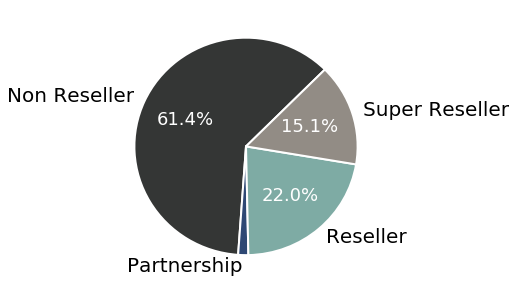

In [105]:
def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 5 else ''

fig, ax = plt.subplots(figsize = (5,5))

labs = a.index.tolist()
labs = [x.title() for x in labs]

wedges, labels, texts = ax.pie(a.iloc[:,0],
                               colors = colors,
                               rotatelabels = False,
                               labels = labs,
                               autopct = my_autopct,
                               startangle = 45)

ax.set_ylabel('')

for l in labels:
    l.set_fontsize(20)

for t in texts:
    t.set_fontsize(18)
    t.set_color('white')

for i in range(len(wedges)):
    wedges[i].set_linewidth(2)
    wedges[i].set_edgecolor('white')   
    
plt.savefig(image_path + 'Revenue by Customer Type Chart', bbox_inches = 'tight')

### Gross Profit

In [106]:
main = op_main.groupby(report_type)[['revenue','gross profit']].sum()
main['gross profit margin'] = main['gross profit']/main['revenue']

a = main.iloc[-1]['gross profit']
b = main.iloc[-1]['gross profit margin']
c = main['gross profit margin'].mean()

if np.abs(b-c) < 0.02:
    ret = 'about equal to'
else:
    if b < c:
        ret = 'below'
    else:
        ret = 'above'

w1 = 'Gross Profit totaled ${:,.0f}, which makes for an overall gross profit margin of {:,.1f}%, {} the {} average of {:,.1f}%.'.format(a,
                                                                                                                                    b * 100,
                                                                                                                                    ret,
                                                                                                                                    report_type.split(' ')[-1] + 'ly',
                                                                                                                                    c * 100)
s = 'gross profit margin was {:,.1f}% and {} the average;'.format(b * 100, ret)
summary_ls.append(s)

report_dict['gross profit write'] = w1
report_dict['gross profit write']

'Gross Profit totaled $2,058,866, which makes for an overall gross profit margin of 59.3%, about equal to the monthly average of 59.4%.'

### Order Count + Average Order Value

In [107]:
main = op_main.groupby(report_type).agg({'revenue':'sum','orders id':'nunique'}).rename(columns = {'orders id':'order count'})
main['aov'] = main['revenue']/main['order count']

main_count = main[['order count']]

main_aov = main[['aov']]

a = main_count.iloc[-1]['order count']
b = main_count.iloc[-period - 1]['order count']
c = a/b-1


w1 = 'The order count {} {:,.1f}% year over year, {} from x{:,.0f} to x{:,.0f}.'.format('decreased' if c < 0 else 'increased',
                                                                                        np.abs(c) * 100,
                                                                                        'down' if c < 0 else 'up',
                                                                                        b,
                                                                                        a)

s = 'order count {} {:,.1f}%;'.format('decreased' if c < 0 else 'increased', np.abs(c) * 100)
summary_ls.append(s)

a = main.iloc[-1]['aov']
b = main['aov'].mean()

if np.abs(a-b) < 2.00:
    ret = 'about equal to'
else:
    if a < b:
        ret = 'below'
    else:
        ret = 'above'

w2 = 'The overall average order value was ${:,.2f}, {} the {} average of ${:,.2f}.'.format(a,
                                                                                          ret,
                                                                                          report_type.split(' ')[-1] + 'ly',
                                                                                          b)

s = 'overall average order value was ${:,.2f};'.format(a)
summary_ls.append(s)

write = ' '.join([w1,w2])
report_dict['order count and aov write'] = write
print(report_dict['order count and aov write'])

The order count decreased 6.1% year over year, down from x26,632 to x25,008. The overall average order value was $138.89, below the monthly average of $145.95.


### Average Order Value by Customer Type

In [108]:
main = op_main.groupby([report_type,'customer']).agg({'revenue':'sum','orders id':'nunique'}).rename(columns = {'orders id':'order count'})
main['aov'] = main['revenue']/main['order count']
main = main[['aov']].unstack(1)
main.columns = main.columns.droplevel(0)

# YoY change
main2 = main.pct_change(periods = period)

# proportion of total
main3 = main.div(main.sum(1).values, axis = 0)

a = main.iloc[[-1]].T
a.columns = [report_type_pretty]

b = main2.iloc[[-1]].T
b.columns = ['YoY Change']

c = a.join(b)
c.sort_values(report_type_pretty, ascending = False, inplace = True)
c.reset_index(inplace = True)
c.rename(columns = {'customer':'Customer'}, inplace = True)
c['Customer'] = [x.title() for x in c['Customer']]

fmt = [0,'m2','p1']
c2 = c.format_(fmt)

report_dict['aov by customer type'] = c2.to_html(index = False)

### Freebies

In [109]:
freebies_main = op_main[(op_main['qty free'] > 0)].copy()

oids = freebies_main['orders id'].tolist()

orders = op_main[op_main['orders id'].isin(oids)].groupby(report_type)[['orders id']].nunique()
orders.columns = ['order count']

rev = op_main[op_main['orders id'].isin(oids)].groupby(report_type)[['revenue']].sum()
total = op_main.groupby(report_type)[['revenue']].sum()

prop = rev.div(total, axis = 1)
prop.columns = ['proportion']

aov = rev.div(orders.values, axis = 1)
aov.columns = ['aov']

a = prop.iloc[-1]['proportion']
b = prop['proportion'].mean()

if np.abs(a-b) < 0.05:
    ret = 'about equal to'
else:
    if a < b:
        ret = 'below'
    else:
        ret = 'above'

w1 = 'Revenue for orders which contain freebies constituted {:,.1f}% of total revenue, {} the average of {:,.1f}%.'.format(a * 100,
                                                                                                                           ret,
                                                                                                                           b * 100)

a = aov.iloc[-1]['aov']
b = aov['aov'].mean()

if np.abs(a-b) < 2:
    ret = 'about equal to'
else:
    if a < b:
        ret = 'below'
    else:
        ret = 'above'
        
w2 = 'The average order value for these same orders came to ${:,.2f}, {} the {} average of ${:,.2f}.'.format(a,
                                                                                                             ret,
                                                                                                             report_type.split(' ')[-1] + 'ly',
                                                                                                             b)

write = ' '.join([w1,w2])
report_dict['freebies write'] = write
report_dict['freebies write']

'Revenue for orders which contain freebies constituted 37.6% of total revenue, about equal to the average of 36.2%. The average order value for these same orders came to $269.14, below the monthly average of $274.91.'

### Parts With a Gross Profit Loss

In [110]:
main = loss_main[loss_main['qty free'] == 0].groupby(report_type)[['gross profit']].sum()
main = np.abs(main)
main.columns = ['gross profit loss']

a = main.iloc[-1]['gross profit loss']
b = main['gross profit loss'].mean()

if np.abs(a-b) < 200:
    ret = 'about equal to'
else:
    if a < b:
        ret = 'below'
    else:
        ret = 'above'
        
w1 = 'Adafruit lost ${:,.0f} in gross profit, {} the {} average of ${:,.0f}.'.format(a,
                                                                                     ret,
                                                                                     report_type.split(' ')[-1] + 'ly',
                                                                                     b)

s = 'gross profit loss, excluding freebies, was {} the average;'.format(ret)
summary_ls.append(s)

report_dict['parts with gross profit loss write'] = w1
print(report_dict['parts with gross profit loss write'])

#fmt = [0,0,'m2']
#a = cur_loss_no_freebies[['gross profit']].reset_index().format_(fmt)
#report_dict['parts with gross profit loss table'] = a.to_html(index = False)

Adafruit lost $6,645 in gross profit, about equal to the monthly average of $6,463.


### Manufacturing

In [111]:
main = op_main[(op_main['bom type'].isin(pnp_boms)) & (op_main['consigned'] == 'no')].groupby(report_type)[['revenue','gross profit']].sum()
main['gross profit margin'] = main['gross profit']/main['revenue']

t = op_main.groupby(report_type)[['revenue']].sum()

main['revenue as % of total'] = main[['revenue']].div(t.values, axis = 1)

a = main.iloc[-1]['revenue']
b = main.iloc[-period - 1]['revenue']
c = a/b-1

w1 = 'Manufacturing revenue {} {:,.1f}% year over year, {} from ${:,.0f} to ${:,.0f}.'.format('grew' if c > 0 else 'fell',
                                                                                             np.abs(c) * 100,
                                                                                             'up' if c > 0 else 'down',
                                                                                             b,
                                                                                             a)

s = 'manufacturing revenue {} {:,.1f}%;'.format('grew' if c > 0 else 'fell', np.abs(c) * 100)
summary_ls.append(s)

a = main.iloc[-1]['revenue as % of total']
b = main['revenue as % of total'].mean()

if np.abs(a-b) < 0.02:
    ret = 'about equal to'
else:
    if a < b:
        ret = 'below'
    else:
        ret = 'above'

w2 = 'As a proportion of total revenue, it made up {:,.1f}%, {} the {} average of {:,.1f}%.'.format(a * 100,
                                                                                                            ret,
                                                                                                            report_type.split(' ')[-1] + 'ly',
                                                                                                            b * 100)

a = main.iloc[-1]['gross profit margin']
b = main['gross profit margin'].mean()

if np.abs(a-b) < 0.02:
    ret = 'about equal to'
else:
    if a < b:
        ret = 'below'
    else:
        ret = 'above'
        
w3 = 'The gross profit margin was {:,.1f}%, {} the average of {:,.1f}%.'.format(a * 100,
                                                                                  ret,
                                                                                  b * 100)

write = ' '.join([w1,w2,w3])
report_dict['manufacturing write'] = write
report_dict['manufacturing write']

'Manufacturing revenue grew 13.5% year over year, up from $746,070 to $846,534. As a proportion of total revenue, it made up 24.4%, about equal to the monthly average of 23.9%. The gross profit margin was 74.8%, about equal to the average of 74.4%.'

### Profit Margin by BOM

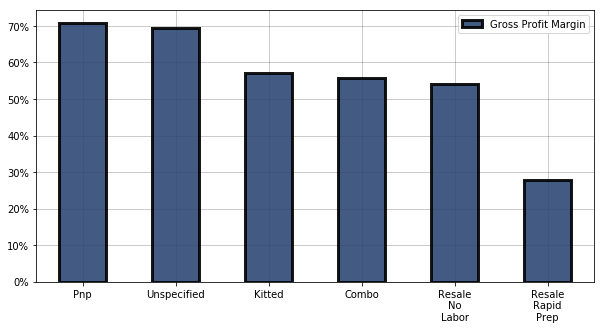

In [112]:
main = op_main[op_main['date purchased'].between(report_date_start, date_end)].groupby('alt bom type')[['revenue','gross profit']].sum()
main['gross profit margin'] = main['gross profit']/main['revenue']
main.sort_values('gross profit margin', ascending = False, inplace = True)
main.reset_index(inplace = True)
main.rename(columns = {'alt bom type':'BOM'}, inplace = True)

t = op_main[op_main['date purchased'].between(report_date_start, date_end)]['revenue'].sum()

if np.abs(main['revenue'].sum() - t) > 1:
    raise ValueError('check ur revenue totals!')

main2 = main[['BOM','gross profit margin']].copy()
main2.drop(main2[main2['gross profit margin'] == 0].index, inplace = True)
main2['BOM'] = [x.title() for x in main2['BOM']]

fmt = [0,'p1']
report_dict['gross profit margin by bom table'] = main2.format_(fmt).to_html(index = False)

fig, ax = plt.subplots(figsize = (10,5))

chart = main2.set_index('BOM')
chart.plot(kind = 'bar', 
           ax = ax,
           color = colors[1],
           edgecolor = 'black',
           lw = 3,
           zorder = 5,
           alpha = 0.90)

ax.set_yticklabels(['{:,.0f}%'.format(x * 100) for x in ax.get_yticks()], fontsize = 10)

xticks = main2['BOM'].tolist()
xticks = [x.replace('- ', '') for x in xticks]
xticks = [x.replace(' ', '\n') for x in xticks]
ax.set_xticklabels(xticks, rotation = 0, fontsize = 10)

ax.set_xlabel('')
ax.grid(color = 'black', alpha = 0.25, zorder = 0)
ax.legend(['Gross Profit Margin'])

plt.show()

fig.savefig(image_path + 'Gross Profit Margin by BOM Chart', bbox_inches = 'tight')

### New Products

In [113]:
main = op_main[op_main['new product over time'] == 'yes']

main2 = main.groupby(report_type)[['revenue','gross profit']].sum()
main2['gross profit margin'] = main2['gross profit']/main2['revenue']

total = op_main.groupby(report_type)[['revenue']].sum()
total.columns = ['total revenue']

main2 = main2.join(total)

main2['revenue as % of total'] = main2['revenue']/main2['total revenue']

a = len(set(op_main[op_main['new product'] == 'yes']['part id']))
b = main2.iloc[-1]['revenue']
c = main2.iloc[-1]['revenue as % of total']
d = main2['revenue as % of total'].mean()

if np.abs(c-d) < 0.002:
    ret = 'about equal to'
else:
    if c < d:
        ret = 'below'
    else:
        ret = 'above'

w1 = 'x{} new products were released, and the revenue amounted to ${:,.0f}, {:,.1f}% of total revenue, {} the average of {:,.1f}%.'.format(a, b, c * 100, ret, d * 100)

report_dict['new products write'] = w1
print(report_dict['new products write'])

s = 'new products revenue made up {:,.1f}% of total revenue.'.format(c * 100)
summary_ls.append(s)

x46 new products were released, and the revenue amounted to $61,976, 1.8% of total revenue, above the average of 1.5%.


### By Category

In [114]:
main = op_main.groupby([report_type,'category'])[['revenue','gross profit']].sum()
main['gross profit margin'] = main['gross profit']/main['revenue']

main2 = main[main.index.get_level_values(0) == main.index.get_level_values(0).max()].copy()
main2.sort_values('revenue', ascending = False, inplace = True)
main2 = main2.iloc[:5,:]

ls = main2.index.get_level_values(1).tolist()

ls2 = []
for i in range(len(ls)):
    if i != len(ls) - 1:
        ls2.append(ls[i] + ', ')
    else:
        ls2.append('and ' + ls[i] + '.')
        
w1 = 'The top five categories by revenue were {}'.format(''.join(ls2))

t1 = main2['revenue'].sum()
t2 = op_main[op_main['date purchased'].between(report_date_start, date_end)]['revenue'].sum()
t3 = t1/t2

avg = main2['gross profit margin'].mean()

w2 = 'The combined revenue amounted to {:,.1f}% of total revenue, and the average gross profit margin was {:,.1f}%.'.format(t3 * 100, avg * 100)

write = ' '.join([w1,w2])
report_dict['by category'] = write
print(report_dict['by category'])

fig = category_d['by category pie chart']
fig.savefig(image_path + 'By Category Pie Chart', bbox_inches = 'tight')
plt.close()

The top five categories by revenue were Raspberry Pi, Development Boards, Sensors, Power, and Breakout Boards. The combined revenue amounted to 53.9% of total revenue, and the average gross profit margin was 61.0%.


### By BOM

In [115]:
main = op_main.groupby([report_type,'alt bom type'])[['revenue']].sum()

ls = sorted(list(set(main.index.get_level_values(0))))
cur = ls[-1]
prev = ls[-period - 1]

a = main[main.index.get_level_values(0) == cur]
a.columns = ['current']
a.reset_index(level = 0, drop = True, inplace = True)

b = main[main.index.get_level_values(0) == prev]
b.columns = ['one year ago']
b.reset_index(level = 0, drop = True, inplace = True)

main2 = a.join(b)
main2['yoy'] = main2['current']/main2['one year ago']

main2.drop('one year ago', 1, inplace = True)

t = op_main[op_main['date purchased'].between(report_date_start, date_end)]['revenue'].sum()

main2['% of total'] = main2[['current']]/t

if main2['% of total'].sum() < 0.99999999:
    raise ValueError('check ur sum')
    
main2.reset_index(inplace = True)
main2.rename(columns = {'alt bom type':'BOM'}, inplace = True)
main2.sort_values('% of total', ascending = False, inplace = True)

main2['BOM'] = [x.title() for x in main2['BOM']]

fmt = [0,'m0','p1','p1']
report_dict['by bom table'] = main2.format_(fmt).to_html(index = False)

fig = bom_d['by bom pie chart']
fig.savefig(image_path + 'by BOM Pie Chart', bbox_inches = 'tight')
plt.close()

### Write it

In [116]:
summary = ' '.join(summary_ls)
summary

'Year over year, revenue decreased 1.5%; gross profit margin was 59.3% and about equal to the average; order count decreased 6.1%; overall average order value was $138.89; gross profit loss, excluding freebies, was about equal to the average; manufacturing revenue grew 13.5%; new products revenue made up 1.8% of total revenue.'

In [117]:
if write_pdf == 'yes':
    
    from jinja2 import Environment, FileSystemLoader
    env = Environment(loader = FileSystemLoader(html_path))

    template = env.get_template(html_title)

    template_vars = {'title':report_title.split(' - ')[-1],
                    'subtitle':report_type_pretty,
                    'now':now_pretty,
                    'report_type':report_type.split(' ')[-1] + 'ly',
                    'report_type2':report_type.split(' ')[-1],
                    'report_type3':report_type,
                     
                    'summary':summary,
                    
                    'revenue_write':report_dict['revenue write'],
                     
                    'partnership_write':report_dict['partnership write'],
                    
                    'revenue_by_customer_type_table':report_dict['revenue by customer type table'],
                    
                    'gross_profit_write':report_dict['gross profit write'],
                     
                    'gross_profit_margin_by_bom_table':report_dict['gross profit margin by bom table'],
                    
                    'order_count_and_aov_write':report_dict['order count and aov write'],
                    
                    'aov_by_customer_type':report_dict['aov by customer type'],
                    
                    'freebies_write':report_dict['freebies write'],
                    
                    'parts_with_gross_profit_loss_write':report_dict['parts with gross profit loss write'],
                    
                    'manufacturing_write':report_dict['manufacturing write'],
                     
                    'new_products_write':report_dict['new products write'],
                    
                    'by_category':report_dict['by category'],
                    
                    'by_bom_table':report_dict['by bom table']}

    html_out = template.render(template_vars)

    from weasyprint import HTML

    HTML(string = html_out).write_pdf(pdf_path + report_title + '.pdf',
                                      stylesheets = [style_sheet_path])                               

In [118]:
print('done')

done
